<a href="https://colab.research.google.com/github/F-Aghaee/tutorials/blob/master/Copy_of_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Translation with a Sequence to Sequence Network and Attention**

************************

Requirements
==================



In [0]:
%matplotlib inline

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading data files
==================

The data for this project is a tab separated list of many thousands of English to French translation pairs.

I want to represent each word in a language as a one-hot vector, or giant vector of zeros except for a single one.
Because each language has very large number of words, we will have very large encoding vector so I trim the data to only use a few thousand words per language.

I need a unique index per word to use as the inputs and targets of the networks later. So use a helper class
called ``Vocabulary`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, and count of each word ``word2count`` to use to later replace rare words.



In [0]:

SOS_token, EOS_token = 0, 1

class Vocabulary :
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The file is in Unicode, I turn Unicode characters to ASCII, make everything lowercase, and trim most
punctuation.




In [0]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

I split the file into lines, and then split lines into pairs. The lines type will be list and pairs is a list of lists of two sentences . The file is English to France, so if we want to translate from france to English I added the reverse flag to reverse the pairs.




In [0]:
def readvocabularies(lang1, lang2,reverse=False):

    # Read the file and split into lines.
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Vocabulary instances
    if reverse:
         pairs = [list(reversed(p)) for p in pairs]
         source_lang = Vocabulary(lang2)
         target_lang = Vocabulary(lang1)
    else:

         source_lang = Vocabulary(lang1)
         target_lang = Vocabulary(lang2)

    return source_lang, target_lang, pairs
    # source_lang and target_lang are Vocabulary class instances
    # pairs is a list of lists of two sentence


Since there are a lot of example sentences and I want to train something quickly, I filter the data and trim it set to short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and I only use the source sentences that start with the form "I am" or "He is" etc. (accounting for apostrophes replaced earlier).




In [0]:
MAX_LENGTH = 10

eng_prefixes = (
   "i am ", "i m ",
   "he is", "he s ",
   "she is", "she s",
   "you are", "you re ",
   "we are", "we re ",
   "they are", "they re ") 


def filterPair(p):
    # p is a list of two sentences

    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
         p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    # pairs is a list of lists of two sentence

    return [pair for pair in pairs if filterPair(pair)]

Finally the full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [42]:
def prepareData(lang1, lang2,reverse=False):
    source_lang, target_lang, pairs = readvocabularies(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    for pair in pairs:
        source_lang.addSentence(pair[0])
        target_lang.addSentence(pair[1])
    print("Count of words in each language:")
    print(source_lang.name, source_lang.n_words)
    print(target_lang.name, target_lang.n_words)
    return source_lang, target_lang, pairs


source_lang, target_lang, pairs = prepareData( 'eng', 'fra')
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Count of words in each language:
eng 2925
fra 4489
['he is by nature a generous person .', 'c est par nature une personne genereuse .']


The Sequence to Sequence Model
=================

I use two RNNs (network that operates on a sequence and uses its own output as input for subsequent steps) to make a Sequence to Sequence network or Encoder_Decoder
network that consisting of two RNNs called the encoder and decoder. This model is ideal for translation between two
languages.

The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.




The Encoder
-----------

The encoder of a seq2seq network outputs some value for
every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.




In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        # input_size: the number of words in source language
        
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):                                            
        # input shape:[1],takes value in range(input_size)
        # hidden shape: [1, 1, hidden_size]
        
        embedded = self.embedding(input)                                         
        # embedded shape: [1, hidden_size]

        output = embedded.view(1, 1, -1)
        # output shape: [1, 1, hidden_size]
        
        output, hidden = self.gru(output, hidden)
        # hidden shape: [1, 1, hidden_size]
        # output shape: [1, 1, hidden_size]

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

In the simple seq2seq decoder we can use only last output of the encoder that called the *context vector* and use as the initial hidden state of the decoder. At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string ``<SOS>`` token, and the first hidden state is the context vector (the encoder's last hidden state). 

If only the context vector is passed betweeen the encoder and decoder,that single vector carries the burden of encoding the entire sentence. But we can use attention decoder for more better results.




**Attention Decoder**


Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Calculating the attention weights is done with another feed-forward layer ``attn``, using the decoder's input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer I have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.




In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        # output_size: the number of words in target language

        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # input shape:[1,1],takes value in range(output_size)
        # hidden shape: [1, 1, hidden_size]

        embedded = self.embedding(input).view(1, 1, -1)
        # embedded shape: [1, 1, hidden_size]

        embedded = self.dropout(embedded)
        # embedded shape: [1, 1, hidden_size]
        
        attn_weights = self.attn(torch.cat((embedded[0], hidden[0]), 1))
        # torch.cat shape: [1, hidden_size + hidden_size]
        # attn_weights shape: [1, max_length]

        attn_weights = F.softmax(attn_weights, dim=1)
        # attn_weights shape: [1, max_length]
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        # attn_applied shape: [1, 1, hidden_size]

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # output shape: [1, hidden_size + hidden_size]

        output = self.attn_combine(output).unsqueeze(0)
        # output shape: [1, 1, hidden_size]

        output = F.relu(output)
        # output shape: [1, 1, hidden_size]

        output, hidden = self.gru(output, hidden)
        # hidden shape: [1, 1, hidden_size]
        # output shape: [1, 1, hidden_size]

        output = self.out(output[0])
        # output[0] shape: [1, hidden_size]
        # output shape: [1, output_size]

        output = F.log_softmax(output, dim=1)
        # output shape: [1, output_size]

        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [0]:
def indexesFromSentence(Vocabulary, sentence):
    return [Vocabulary.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(Vocabulary, sentence):
    indexes = indexesFromSentence(Vocabulary, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(source_lang, pair[0])
    target_tensor = tensorFromSentence(target_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1, plot_every=1, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [0]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(source_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(target_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




0m 0s (- 0m 0s) (1 10%) 8.4133
0m 0s (- 0m 0s) (2 20%) 8.3875
0m 0s (- 0m 0s) (3 30%) 8.3327
0m 0s (- 0m 0s) (4 40%) 8.3554
0m 0s (- 0m 0s) (5 50%) 8.2836
0m 0s (- 0m 0s) (6 60%) 4.8456
0m 0s (- 0m 0s) (7 70%) 3.3206
0m 0s (- 0m 0s) (8 80%) 4.8595
0m 0s (- 0m 0s) (9 90%) 8.2724
0m 0s (- 0m 0s) (10 100%) 8.1288


<Figure size 432x288 with 0 Axes>

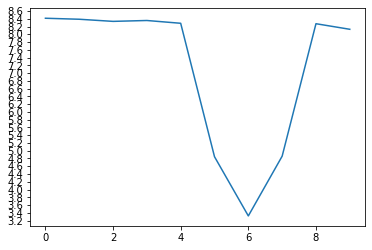

In [59]:
hidden_size = 256
encoder1 = EncoderRNN(source_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, target_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 10, print_every=1)

In [53]:
evaluateRandomly(encoder1, attn_decoder1)

> i m shorter than him .
= je suis plus petit que lui .
< je je . <EOS>

> i am disappointed at the news .
= je suis decu par les nouvelles .
< je . <EOS>

> i m willing to accept your offer .
= je suis d accord d accepter votre offre .
< je je . <EOS>

> i am looking for my brother .
= je cherche mon frere .
< je je . <EOS>

> you re the teacher .
= c est vous l enseignante .
< je je . <EOS>

> i am sorry if i disturbed you .
= je suis desolee si je t ai derange .
< je je . <EOS>

> you re very observant .
= vous etes tres observatrice .
< je je . <EOS>

> they re all against me .
= elles sont toutes contre moi .
< je je . <EOS>

> i m not that fast .
= je ne suis pas si rapide .
< je je . <EOS>

> i am about to leave here .
= je suis sur le point de quitter ici .
< je je . <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




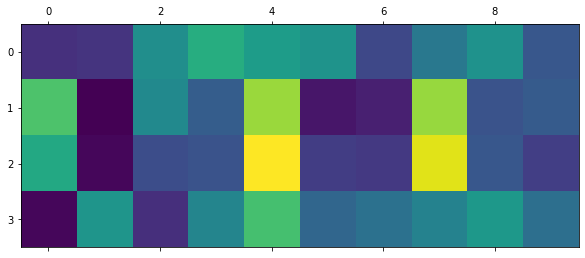

In [54]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "i m laying you off .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




input = she is five years younger than me .
output = je je . <EOS>


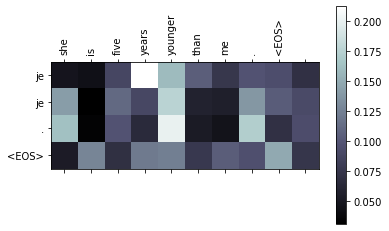

input = she is too small .
output = je je . <EOS>


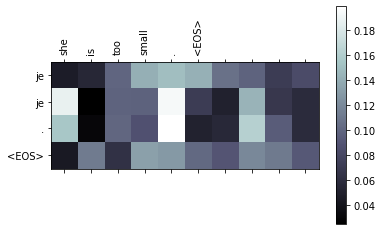

input = i m not afraid of dying .
output = je je . <EOS>


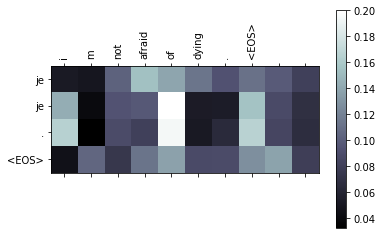

input = i m not afraid of dying .
output = je je . <EOS>


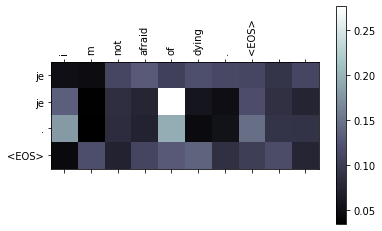

In [57]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("she is five years younger than me .")

evaluateAndShowAttention("she is too small .")

evaluateAndShowAttention("i m not afraid of dying .")

evaluateAndShowAttention("i m not afraid of dying .")
